In [972]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
import time
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
import catboost as cb
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.model_selection import GroupKFold
from typing import List, Optional
import re
from scipy.stats import gmean, rankdata
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
import missingno as msno

from imblearn.over_sampling import SMOTE # важно до sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

In [973]:
train = pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/lib/train.csv")
test = pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/lib/test.csv")

In [974]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [975]:
train = train.rename(columns = lambda x:re.sub(' ', '_', x))
train.columns = train.columns.str.lower()

test = test.rename(columns = lambda x:re.sub(' ', '_', x))
test.columns = test.columns.str.lower()

# Анализ пропусков

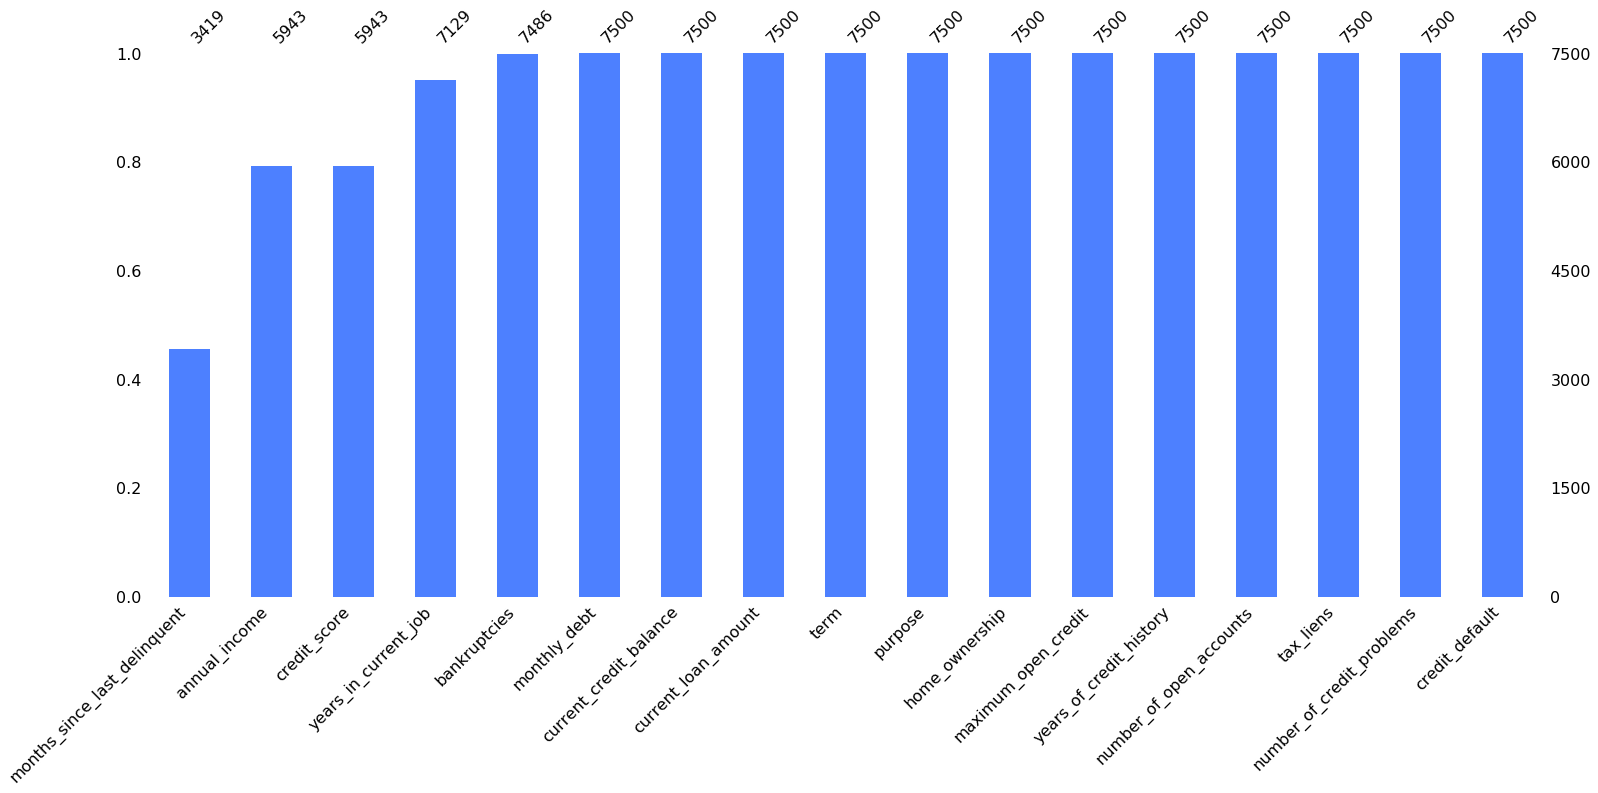

In [977]:
msno.bar(train, labels=True, color=(0.3, 0.5,1), sort='ascending' )

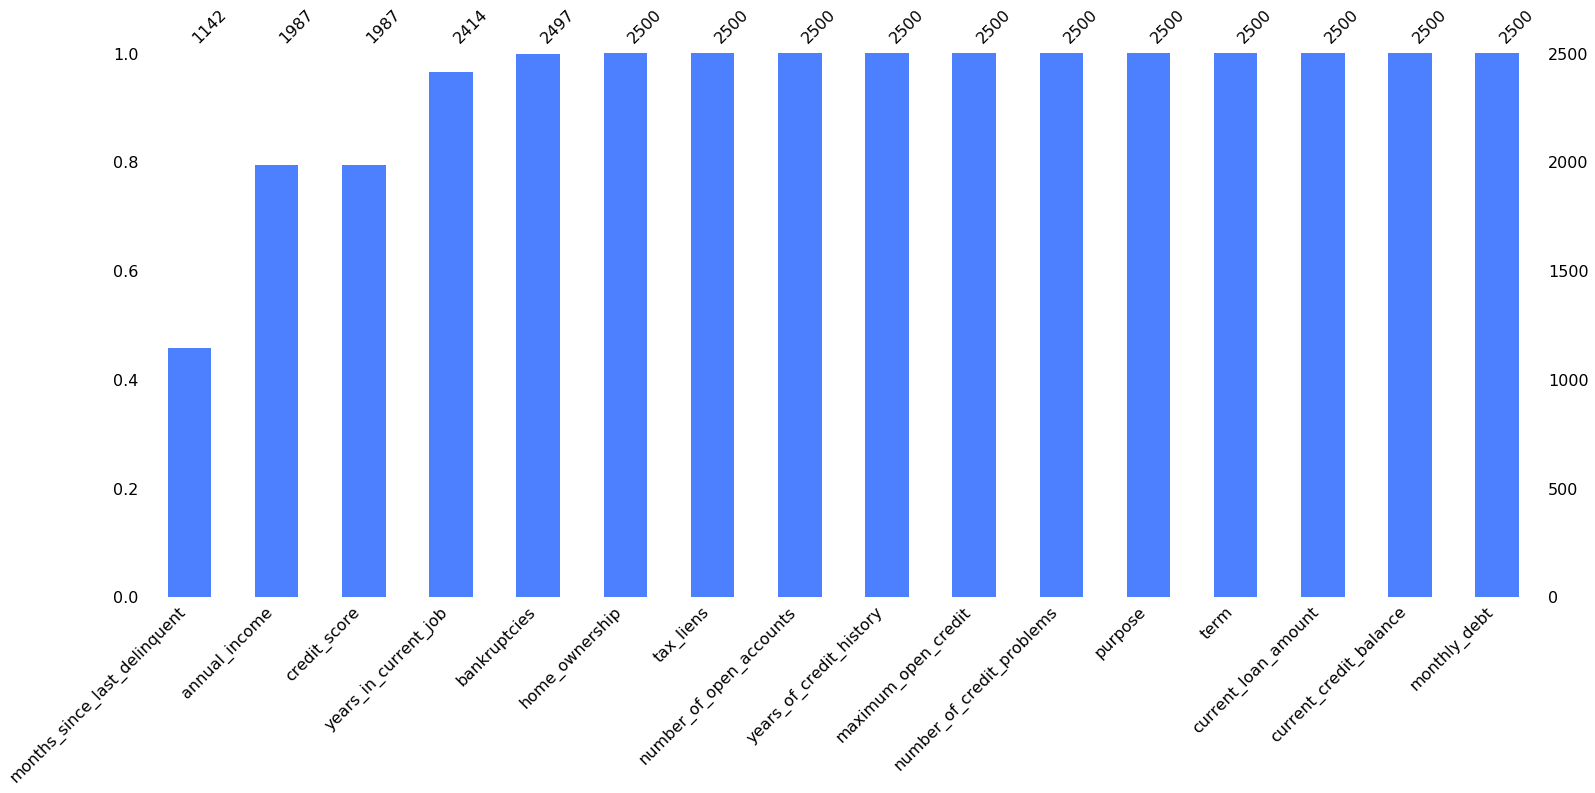

In [978]:
msno.bar(test, labels=True, color=(0.3, 0.5,1), sort='ascending' )

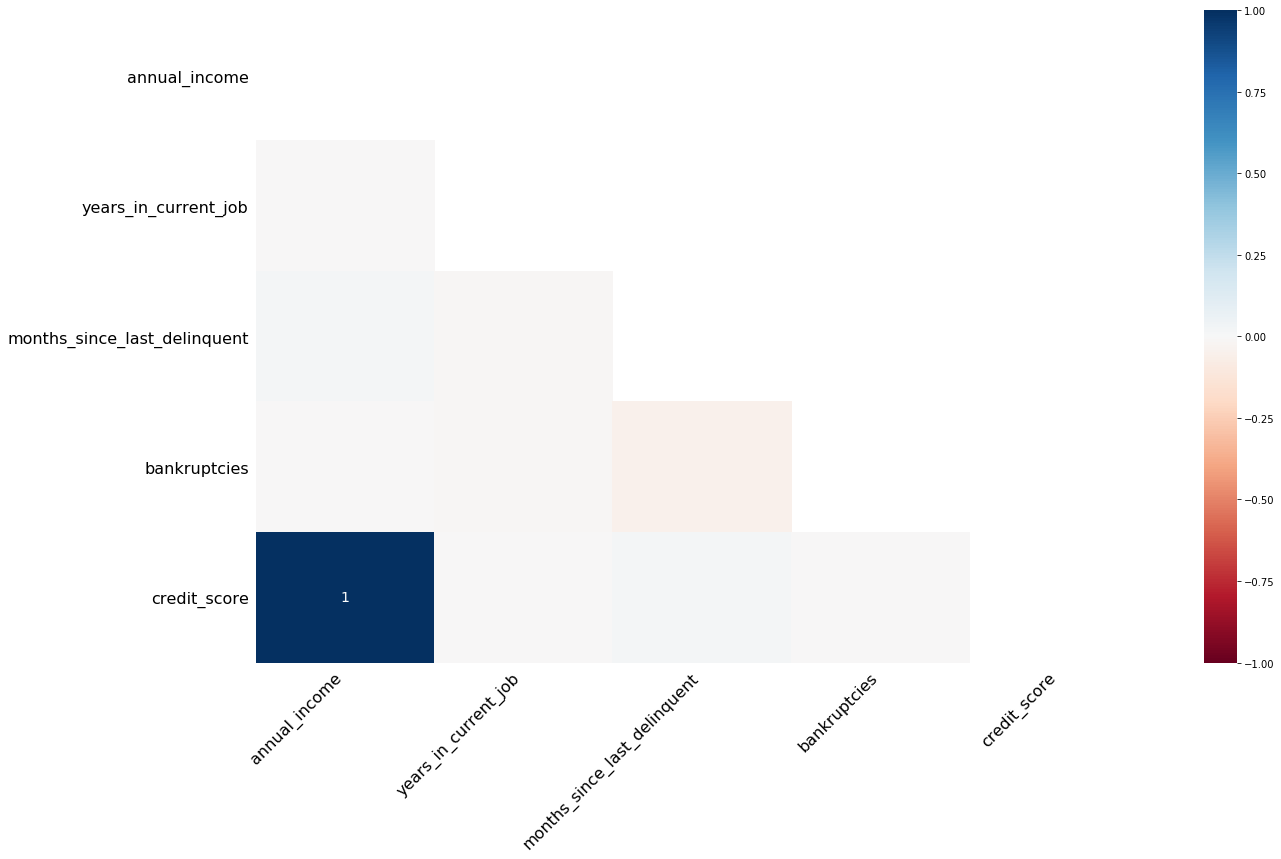

In [979]:
msno.heatmap(train)

In [980]:
features_with_na = [feature for feature in train.columns if train[feature].isnull().sum() > 1]

C:\Users\elousiren\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """


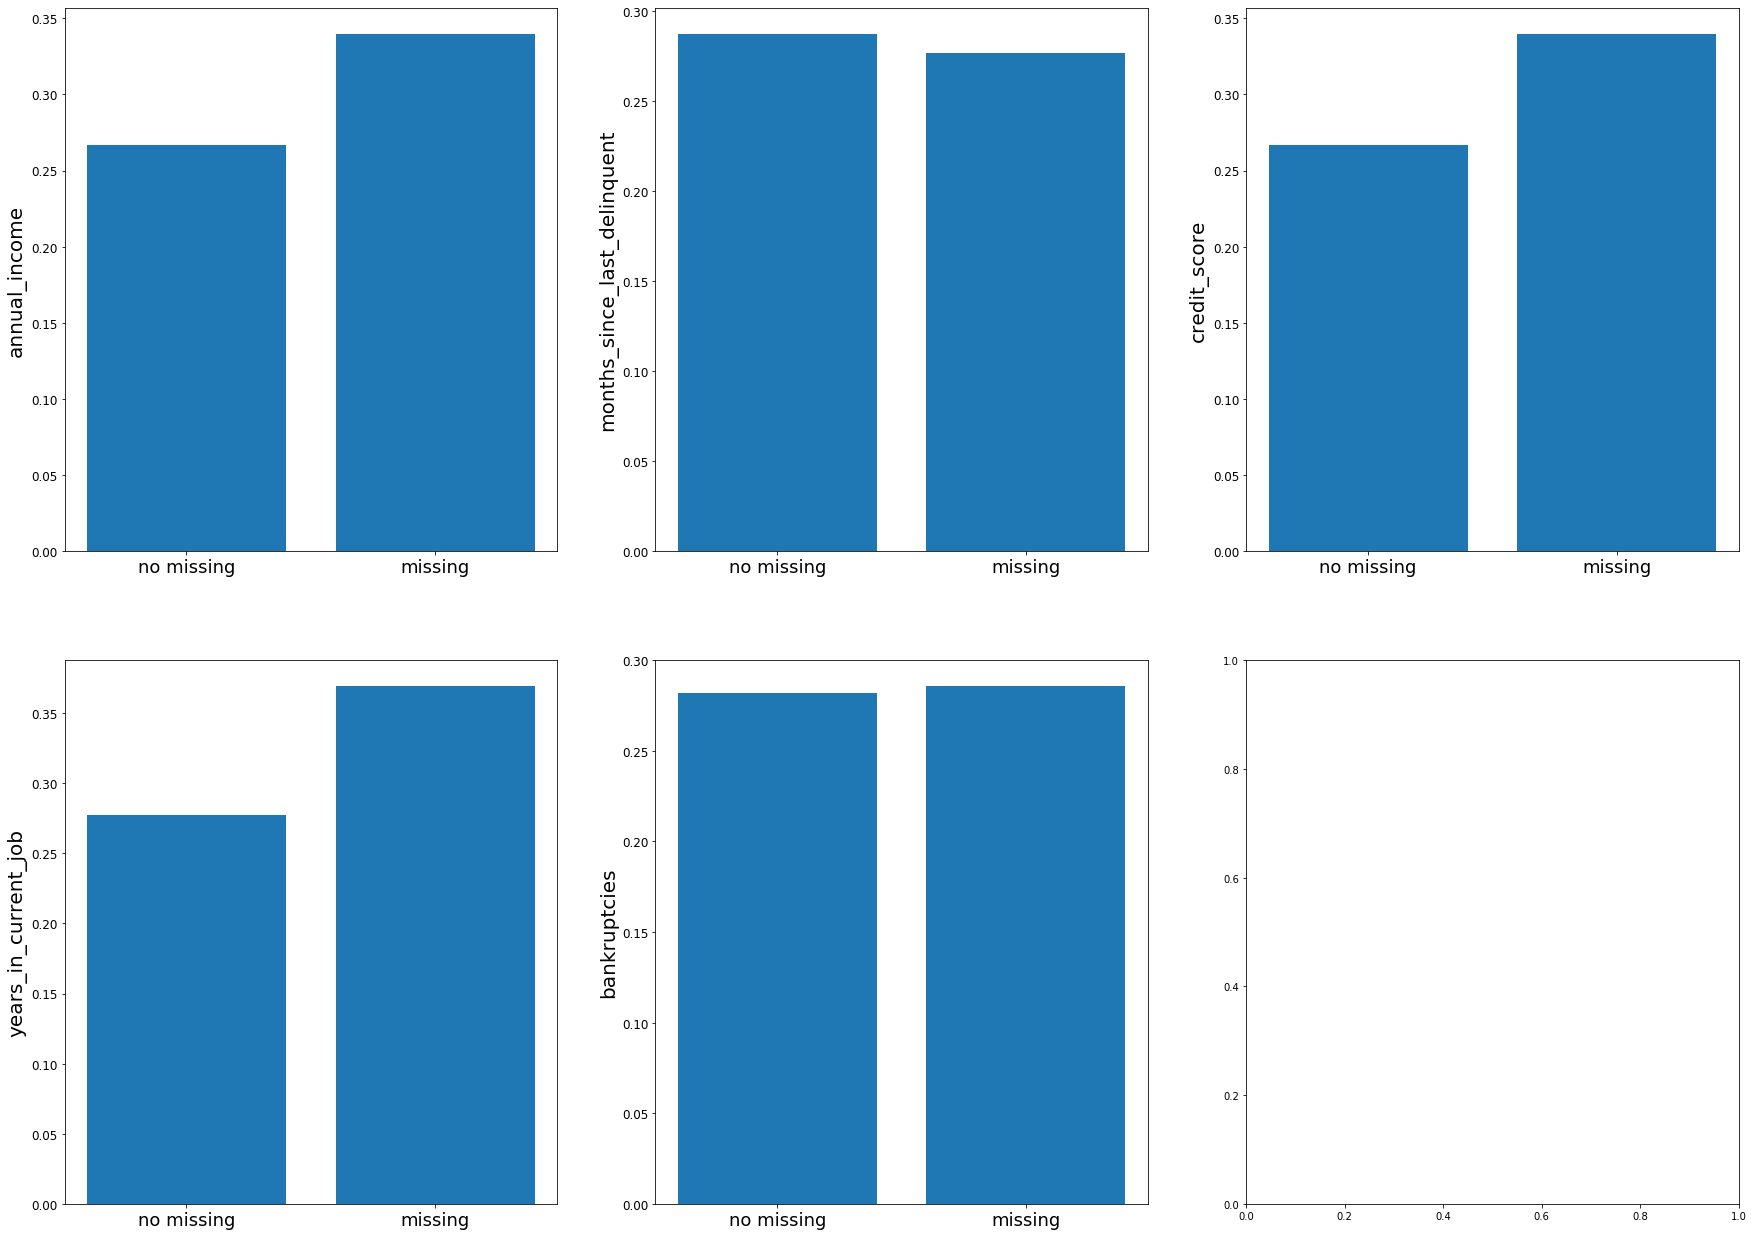

In [981]:
fig, axes = plt.subplots(2, 3, figsize=(30, 22))
for num, feature in enumerate(features_with_na):
    data = train.copy()
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    statistics = data.groupby(feature)["credit_default"].agg(lambda x: x.sum()/x.count()).reset_index()
    axes[num%2, num//2].bar(statistics[feature],statistics["credit_default"])
    axes[num%2, num//2].set_xticks([0, 1])
    axes[num%2, num//2].tick_params(labelsize=12)
    axes[num%2, num//2].set_xticklabels(["no missing", "missing"], fontsize=18)
    axes[num%2, num//2].set_ylabel(feature, fontsize=20)

In [982]:
test['credit_score'].min()

585.0

In [983]:
train['annual_income'].min()

164597.0

Целесообразно заменить на 0

In [984]:
def ch0(df):
    df.loc[df['credit_score'].isnull(),'credit_score'] = 300
    df.loc[df['annual_income'].isnull(),'annual_income'] = 0
    df.loc[df['years_in_current_job'].isnull(),'years_in_current_job'] = '0 year'
    df.loc[df['months_since_last_delinquent'].notnull(),'months_since_last_delinquent'] = 1
    df.loc[df['months_since_last_delinquent'].isnull(),'months_since_last_delinquent'] = 0
    df.loc[df['bankruptcies'].isnull(),'bankruptcies'] =0
    return df

In [985]:

train = ch0(train)
test = ch0(test)

In [986]:
# cs_mean = round(train['credit_score'].mean())
# train.loc[train['credit_score'].isnull(),'credit_score'] = cs_mean
# test.loc[test['credit_score'].isnull(),'credit_score'] = cs_mean

In [987]:
train['current_loan_amount'].min()

11242.0

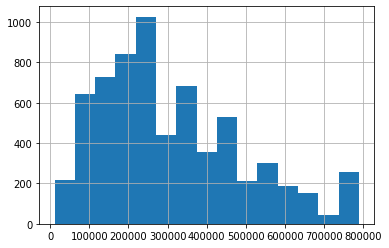

In [988]:
train.loc[train['current_loan_amount']!=99999999.0,'current_loan_amount'].hist(bins=15)

# Преобразование признаков

In [989]:
train['purpose'].value_counts(dropna=False)


debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: purpose, dtype: int64

Большинство целей имеют значение debt consolidation. Сделаем отметку на этой цели 1, на остальных 0.

In [990]:
def mode_purpose(df):
    df.loc[df['purpose']!='debt consolidation', 'purpose'] = 0
    df.loc[df['purpose']=='debt consolidation', 'purpose'] = 1
    df['purpose']=df['purpose'].astype(int) 
    return df

In [991]:
train = mode_purpose(train)
test = mode_purpose(test)

In [992]:
train['home_ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: home_ownership, dtype: int64

In [993]:
train['years_in_current_job'].value_counts(dropna=False)


10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
0 year        371
8 years       339
9 years       259
Name: years_in_current_job, dtype: int64

In [994]:
train.loc[train['years_of_credit_history']>40, 'years_of_credit_history'] =40
test.loc[test['years_of_credit_history']>40, 'years_of_credit_history'] =40

Перевод годов из надписей в года. Новый признак годы: разность лет на работе и лет кредитной истории

In [995]:
def year_mode(df):
    df['years_in_current_job'] = df['years_in_current_job'].str.replace('[^0-9_]+', '').astype(int) 
    df['years'] = df['years_in_current_job']-df['years_of_credit_history']
    return df

In [996]:
train = year_mode(train)
test = year_mode(test)

Переведем года в 3 группы

In [997]:
def year_gr_mode(df):
    df.loc[(df['years_in_current_job']>6)&(df['years_in_current_job']<10),'years_in_current_job'] = 7
    df.loc[(df['years_in_current_job']==10),'years_in_current_job'] = 8
    return df

In [998]:
train = year_gr_mode(train)
test = year_gr_mode(test)

In [999]:
test['home_ownership'].value_counts(dropna=False)

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: home_ownership, dtype: int64

Объединим группы Home Mortgage и Have Mortgage  

In [1000]:
def mortgage(df):
    df.loc[df['home_ownership']=='Have Mortgage', 'home_ownership'] = 'Home Mortgage'
    return df

In [1001]:
train = mortgage(train)
test = mortgage(test)

In [1002]:
def term(df):
    df['term'] = np.where(df['term']=='Short Term', 1, 0)
    return df

In [1003]:
train = term(train)
test = term(test)

Скорректируем выбросы: частое значение 99999999.0 заменим средним, и поставим отметку, что оно было.

In [1004]:
def amount(df, amoun_mean):
    df['no_amount'] = 0
    df.loc[df['current_loan_amount']==99999999.0, 'no_amount'] =1
    df.loc[df['current_loan_amount']==99999999.0, 'current_loan_amount'] = amoun_mean
    return df

In [1005]:
amoun_mean = round(train.loc[train['current_loan_amount']!=99999999.0, 'current_loan_amount'].mean())
train = amount(train, amoun_mean)
test = amount(test, amoun_mean)

In [1006]:
cm = sns.light_palette("green", as_cmap=True)
train.corr().style.background_gradient(cmap=cm)

,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default,years,no_amount
annual_income,1.000000,0.099033,0.043427,0.133662,0.136888,0.006827,-0.011938,0.060036,-0.045282,-0.022728,-0.087480,0.310382,0.283506,0.414244,0.109724,-0.110569,-0.079383,0.133754
years_in_current_job,0.099033,1.000000,0.000031,0.066803,0.132725,0.003696,0.005279,0.041193,0.014664,0.042616,-0.084740,0.150034,0.101443,0.144882,-0.003808,-0.020341,0.370857,-0.000541
tax_liens,0.043427,0.000031,1.000000,-0.005360,0.009843,-0.002410,0.595339,0.053204,0.057423,-0.015876,-0.004953,0.030081,-0.010195,0.027211,0.007632,0.024368,-0.007977,-0.007997
number_of_open_accounts,0.133662,0.066803,-0.005360,1.000000,0.147124,0.023897,-0.017813,0.062793,-0.018859,0.081440,-0.071316,0.201868,0.267325,0.413904,0.013402,0.028884,-0.107191,0.000262
years_of_credit_history,0.136888,0.132725,0.009843,0.147124,1.000000,0.029980,0.071656,0.138464,0.085661,-0.004808,-0.044535,0.144461,0.220079,0.195544,-0.013559,-0.021792,-0.868107,0.010798
maximum_open_credit,0.006827,0.003696,-0.002410,0.023897,0.029980,1.000000,-0.004750,-0.012672,-0.011632,-0.007237,0.006023,0.018996,0.088090,0.010197,-0.007118,-0.014275,-0.026305,-0.002436
number_of_credit_problems,-0.011938,0.005279,0.595339,-0.017813,0.071656,-0.004750,1.000000,0.049814,0.730808,-0.009550,0.020433,-0.061211,-0.124137,-0.042252,-0.016330,0.020088,-0.062122,-0.008268
months_since_last_delinquent,0.060036,0.041193,0.053204,0.062793,0.138464,-0.012672,0.049814,1.000000,-0.005244,-0.016288,-0.004151,-0.006657,-0.093731,0.028612,0.003221,0.011756,-0.108528,-0.021405
bankruptcies,-0.045282,0.014664,0.057423,-0.018859,0.085661,-0.011632,0.730808,-0.005244,1.000000,0.009430,0.030981,-0.091018,-0.142553,-0.078847,-0.023348,0.001640,-0.070637,-0.005680
purpose,-0.022728,0.042616,-0.015876,0.081440,-0.004808,-0.007237,-0.009550,-0.016288,0.009430,1.000000,-0.012243,0.139467,0.082263,0.079160,0.012310,-0.015075,0.026834,-0.003598


In [1007]:
x_data = train.copy()
x_data = x_data.drop(['credit_default', 'home_ownership', 'purpose'], axis=1)

In [1008]:
def plot(x, y=None, title=None, x_label=None, y_label=None, kind='plot', **kwargs):
    f, n = {
        'plot': (plt.plot, 2),
        'line': (plt.plot, 2),
        'scatter': (plt.scatter, 2),
        'hist': (plt.hist, 1),
        'dist': (sns.distplot, 1),
        'box': (sns.boxplot, 1),
        'violin': (sns.violinplot, 1),
        'reg': (sns.regplot, 2),
        'lm': (sns.lmplot, 2),
    }[kind]
    f(x, **kwargs) if n == 1 else f(x, y, **kwargs)
    ax = kwargs['ax'] if 'ax' in kwargs else plt.gca()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    return ax

# Заоднородим данные

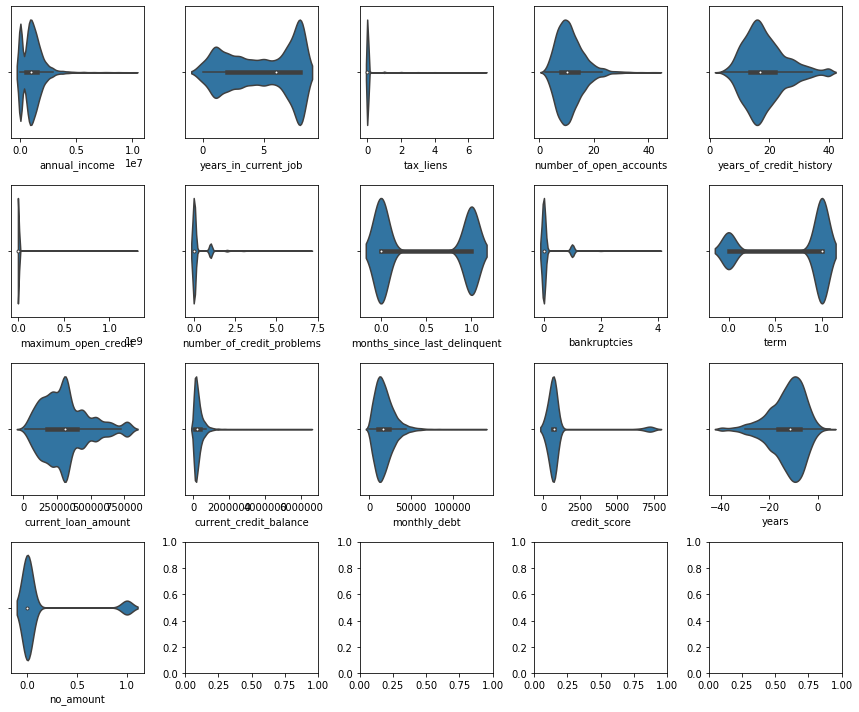

In [1009]:
f, axs = plt.subplots(4, 5, figsize=(12, 10))
axs = axs.flatten()
for i, c in enumerate(x_data.columns):
    plot(train[c], x_label=c, kind='violin', ax=axs[i])
plt.tight_layout()   

In [1010]:
test.describe()

,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,years,no_amount
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.086429e+06,5.058000,0.035200,11.184400,18.274080,7.105704e+05,0.162000,0.45680,0.106800,0.789200,0.744400,312431.803200,2.963966e+05,18271.340000,1042.754000,-12.446080,0.118800
std,9.865642e+05,2.806597,0.386291,4.852774,7.074991,1.511983e+06,0.559894,0.49823,0.356994,0.407958,0.436285,171475.333531,3.783020e+05,11543.881469,1596.616558,7.270331,0.323618
min,0.000000e+00,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,15422.000000,0.000000e+00,93.000000,300.000000,-40.000000,0.000000
25%,5.298672e+05,2.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.00000,0.000000,1.000000,0.000000,187126.500000,1.101145e+05,10024.750000,668.000000,-16.400000,0.000000
50%,9.965215e+05,6.000000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,0.00000,0.000000,1.000000,1.000000,309024.000000,2.073850e+05,16642.500000,722.000000,-11.200000,0.000000
75%,1.488726e+06,8.000000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,1.00000,0.000000,1.000000,1.000000,398893.000000,3.663485e+05,24146.000000,741.000000,-7.400000,0.000000
max,1.497561e+07,8.000000,15.000000,48.000000,40.000000,5.448439e+07,15.000000,1.00000,5.000000,1.000000,1.000000,789096.000000,6.030087e+06,93555.000000,7480.000000,4.500000,1.000000


In [1011]:
annual_income_q9 = train['annual_income'].quantile(.9)
train.loc[train['annual_income']>annual_income_q9 , 'annual_income'] = train.loc[train['annual_income']>annual_income_q9 , 'annual_income']/10
test.loc[test['annual_income']>annual_income_q9 , 'annual_income'] = test.loc[test['annual_income']>annual_income_q9 , 'annual_income']/10


In [1012]:
def tax(df):
    df.loc[df['tax_liens']>1, 'tax_liens'] = 1
    df['tax_liens'] =df['tax_liens'].astype(int) 
    return df

In [1013]:
train = tax(train)
test = tax(test)

In [1014]:
train['number_of_open_accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: number_of_open_accounts, dtype: float64

In [1015]:
test['number_of_open_accounts'].describe()

count    2500.000000
mean       11.184400
std         4.852774
min         1.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        48.000000
Name: number_of_open_accounts, dtype: float64

In [1016]:
acc1 = train["number_of_open_accounts"].quantile(0.25)
acc2 = train["number_of_open_accounts"].quantile(0.5)
acc3 = train["number_of_open_accounts"].quantile(0.75)

In [1017]:
train["number_of_open_accounts"] = train["number_of_open_accounts"].astype(int) 
train["number_of_open_accounts"] =pd.qcut(train["number_of_open_accounts"], 4, [1,2,3,4])
train["number_of_open_accounts"] = train["number_of_open_accounts"].astype(int) 

test["number_of_open_accounts"] = test["number_of_open_accounts"].astype(int) 
test.loc[test['number_of_open_accounts']<=acc1, 'number_of_open_accounts'] =1
test.loc[(test['number_of_open_accounts']>acc1)&(test['number_of_open_accounts']<=acc2), 'number_of_open_accounts'] =2
test.loc[(test['number_of_open_accounts']>acc2)&(test['number_of_open_accounts']<=acc3), 'number_of_open_accounts'] =3
test.loc[test['number_of_open_accounts']>acc3, 'number_of_open_accounts'] =4


In [1018]:
train.loc[train['years_of_credit_history']>40, 'years_of_credit_history'] =40
test.loc[test['years_of_credit_history']>40, 'years_of_credit_history'] =40

In [1019]:
max95 = train['maximum_open_credit'].quantile(.95)
max_mean = int(train['maximum_open_credit'].mean())
train.loc[train['maximum_open_credit']>max95, 'maximum_open_credit'] = max_mean
test.loc[test['maximum_open_credit']>max95, 'maximum_open_credit'] = max_mean


In [1020]:
mask =train["number_of_credit_problems"].value_counts()
train.loc[train['number_of_credit_problems'].isin(mask.index[mask<50]), 'number_of_credit_problems'] = 2
test.loc[test['number_of_credit_problems'].isin(mask.index[mask<50]), 'number_of_credit_problems'] = 2
test.loc[test['number_of_credit_problems']==15, 'number_of_credit_problems'] = 2
train['number_of_credit_problems'] =train['number_of_credit_problems'].astype(int) 
test['number_of_credit_problems'] =test['number_of_credit_problems'].astype(int) 

In [1021]:
train["number_of_credit_problems"].value_counts()

0    6469
1     882
2     149
Name: number_of_credit_problems, dtype: int64

In [1022]:
last_del95 = train['months_since_last_delinquent'].quantile(.95)
train.loc[train['months_since_last_delinquent']>last_del95, 'months_since_last_delinquent'] =last_del95
test.loc[test['months_since_last_delinquent']>last_del95, 'months_since_last_delinquent'] =last_del95

In [1023]:
train.loc[train['bankruptcies']>1, 'bankruptcies'] = 1
test.loc[test['bankruptcies']>1, 'bankruptcies'] = 1
train['bankruptcies'] =train['bankruptcies'].astype(int) 
test['bankruptcies'] =test['bankruptcies'].astype(int) 

In [1024]:
test['bankruptcies'].value_counts()

0    2255
1     245
Name: bankruptcies, dtype: int64

In [1025]:
def cat95(train, test, col):
    for c in col:
        q95 = train[c].quantile(.95)
        mean = train.loc[train[c]<q95,c].mean()
        train.loc[train[c]>=q95, c] = mean
        test.loc[test[c]>=q95, c] = mean
    return train, test

In [1026]:
train, test = cat95(train, test, ['current_credit_balance', 'monthly_debt'])

Excellent: 800 to 850
Very Good: 740 to 799
Good: 670 to 739
Fair: 580 to 669
Poor: 300 to 579

In [1027]:
mean_cs = train.loc[train['credit_score']<1000,'credit_score'].mean()
train.loc[train['credit_score']>1000,'credit_score'] = mean_cs
train['credit_score'] = train['credit_score'].astype(int)
test.loc[test['credit_score']>1000,'credit_score'] = mean_cs
test['credit_score'] = test['credit_score'].astype(int)

In [1028]:
train['credit_score']

0       749
1       737
2       742
3       694
4       719
       ... 
7495    697
7496    628
7497    748
7498    300
7499    300
Name: credit_score, Length: 7500, dtype: int32

In [1029]:
test['credit_score'].describe()

count    2500.000000
mean      628.166000
std       169.898744
min       300.000000
25%       628.000000
50%       715.000000
75%       737.000000
max       751.000000
Name: credit_score, dtype: float64

In [1030]:
bins = [-1, 579, 669, 739, 799, 10000]
train['credit_groupe'] = pd.cut(train['credit_score'], bins=bins, labels=False)
test['credit_groupe'] = pd.cut(test['credit_score'], bins=bins, labels=False)

In [1031]:
for column in train.select_dtypes(include=[np.object]).columns:
        train[column] =  train[column].astype('category')
        test[column] =  test[column].astype('category')

Признаки

In [1032]:
train.loc[train['maximum_open_credit']==0, 'maximum_open_credit'].count()

65

In [1033]:
minopen = train.loc[train['maximum_open_credit']>0, 'maximum_open_credit'].min()
train.loc[train['maximum_open_credit']==0, 'maximum_open_credit'] = minopen/2
test.loc[test['maximum_open_credit']==0, 'maximum_open_credit'] = minopen/2

In [1034]:
def new_f(df):
    df['del_income_debt'] = df['annual_income']/(df['monthly_debt']+1)
    df['del_income_debt'] = df['del_income_debt'].astype(int)           
    df['score'] =round(((df['credit_score']+df['maximum_open_credit']+1))/((df['credit_score']+1)*(df['maximum_open_credit']+1)),3)
    
    return df                                         

In [1035]:
test= new_f(test)
train = new_f(train)

In [1036]:
del99 = train['del_income_debt'].quantile(.99)
train.loc[train['del_income_debt']>del99, 'del_income_debt'] = del99
test.loc[test['del_income_debt']>del99, 'del_income_debt'] = del99

In [1037]:
train.loc[train['del_income_debt']>train['del_income_debt'].quantile(.99), ['annual_income', 'monthly_debt', 'del_income_debt']]

,annual_income,monthly_debt,del_income_debt
6,1511108.0,2317.0,483.04
97,840541.0,483.0,483.04
151,1440257.0,2953.0,483.04
244,1325212.0,906.0,483.04
309,1245792.0,395.0,483.04
...,...,...,...
6740,241419.7,483.0,483.04
6983,2029124.0,3821.0,483.04
7135,1914250.0,941.0,483.04
7144,1987875.0,1590.0,483.04


In [1038]:
train.loc[train['maximum_open_credit']>0, 'maximum_open_credit'].describe()

count    7.500000e+03
mean     5.579683e+05
std      3.556035e+05
min      2.167000e+03
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.706320e+06
Name: maximum_open_credit, dtype: float64

In [1039]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   home_ownership                7500 non-null   category
 1   annual_income                 7500 non-null   float64 
 2   years_in_current_job          7500 non-null   int32   
 3   tax_liens                     7500 non-null   int32   
 4   number_of_open_accounts       7500 non-null   int32   
 5   years_of_credit_history       7500 non-null   float64 
 6   maximum_open_credit           7500 non-null   float64 
 7   number_of_credit_problems     7500 non-null   int32   
 8   months_since_last_delinquent  7500 non-null   float64 
 9   bankruptcies                  7500 non-null   int32   
 10  purpose                       7500 non-null   int32   
 11  term                          7500 non-null   int32   
 12  current_loan_amount           7500 non-null   fl

In [1040]:
X = train.drop('credit_default', axis=1)
y = train['credit_default']

# Боремся с дисбалансом

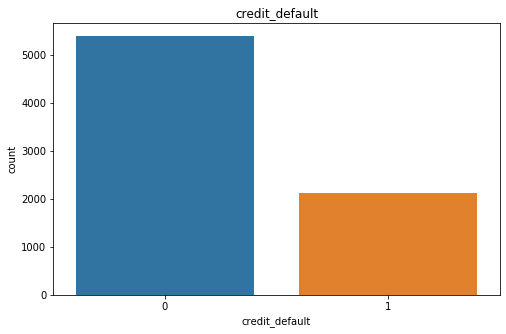

In [1041]:
plt.figure(figsize=(8, 5))

sns.countplot(x='credit_default', data=train)

plt.title('credit_default')
plt.show()

In [1042]:
class UpsampledClassifier(BaseEstimator):
    def __init__(self, model, threshold):
        self.model = model
        self.smoter = SMOTE(random_state=42)
        self.threshold = threshold 
 
    def fit(self, X, y=None):
        X_train_upsample, y_train_upsample = self.smoter.fit_resample(X, y)
        self.model.fit(X_train_upsample, y_train_upsample)
        return self
 
    def predict(self, X, y=None):
        return self.model.predict_proba(X) > self.threshold
 
    def predict_proba(self, X, y=None):
        return self.model.predict_proba(X)

In [ ]:
feat = X.columns.tolist()
#feat.remove('number_of_credit_problems')

# Определяем важность признаков

In [1309]:

X_train_freq, X_test_freq, y_train, y_test = train_test_split(X[feat], y, shuffle=True, test_size=0.30, random_state=21)

In [1310]:
def freq_df(df, test):
    df1 = df.copy()  
    test1 = test.copy()
    for cat in list(df1.select_dtypes(include=['category']).columns):
        freq_encoder = df1[cat].value_counts(normalize=True)
        df1[cat+"_freq_enc"] = df1[cat].map(freq_encoder).astype('float64')
        test1[cat+"_freq_enc"] = test1[cat].map(freq_encoder).astype('float64')
        df1 = df1.drop(cat,axis=1)
        test1 = test1.drop(cat,axis=1)
    return df1, test1

In [1311]:
num = list(X_train_freq.select_dtypes(include=[np.number]).columns)
num.remove('no_amount')
num.remove('term')
num.remove('tax_liens')
num.remove('months_since_last_delinquent')

In [1312]:
X_train_freq, X_test_freq = freq_df(X_train_freq, X_test_freq)

transformer = RobustScaler().fit(X_train_freq[num])



In [1313]:
X_train_freq[num] = transformer.transform(X_train_freq[num])
X_test_freq[num] = transformer.transform(X_test_freq[num])

In [1314]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [1315]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import xgboost as xgb
from sklearn.metrics import fbeta_score

In [1316]:
f1_scorer = make_scorer(f1_score)

In [1317]:
space = {'max_depth': hp.quniform("max_depth", 3, 30, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 5)
        }


In [1318]:
#defining function to optimize
def hyperparameter_tuning(space):
    clf = RandomForestClassifier(n_estimators = int(space['n_estimators']),       #number of trees to use                                                       
                            max_depth = int(space['max_depth']),             #depth of trees
                            random_state=27,    
                            class_weight='balanced', 
                            n_jobs=-1)                                 
    smoter = SMOTE(random_state=42)
    X_train_upsample, y_train_upsample = smoter.fit_resample(X_train_freq, y_train)
        
    clf.fit(X_train_upsample, y_train_upsample)

    pred = clf.predict(X_test_freq)
    pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(y_test, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [1319]:
trials = Trials()
best_forest = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

print(best_forest)

SCORE:                                                                                                                 
0.5206301575393848                                                                                                     
SCORE:                                                                                                                 
0.5106007067137809                                                                                                     
SCORE:                                                                                                                 
0.5222222222222223                                                                                                     
SCORE:                                                                                                                 
0.5187760778859526                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.526829268292683                                                                                                      
SCORE:                                                                                                                 
0.520586182833217                                                                                                      
SCORE:                                                                                                                 
0.5274914089347079                                                                                                     
SCORE:                                                                                                                 
0.5223983459682977                                                                                                     
SCORE:                                  

In [1322]:
model_forest = RandomForestClassifier(random_state=27, max_depth=8, 
                                      n_estimators=185, class_weight='balanced'                             
                                     )
my_classifier_forest = UpsampledClassifier(model=model_forest,threshold=2)
model_forest.fit(X_train_freq, y_train)
model_forest_predictions = model_forest.predict(X_test_freq)

print("F1:", f1_score(y_test, model_forest_predictions, average = 'macro'))

F1: 0.68596025059977


In [1247]:
importance = permutation_importance(
    model_forest, X_test_freq, y_test,scoring=make_scorer(f1_score, average = 'macro'), n_jobs=-1, random_state=42
)

In [1248]:
importance_scores = pd.DataFrame({
    "features": X_test_freq.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)

In [1249]:
importance_scores

,features,importance-mean,importance-std
0,credit_score,0.049495,0.004995
1,annual_income,0.024020,0.003598
2,del_income_debt,0.018725,0.003570
3,term,0.017849,0.002875
4,no_amount,0.017254,0.004834
5,current_loan_amount,0.012296,0.003658
6,score,0.012097,0.001804
7,credit_groupe,0.009321,0.004815
8,maximum_open_credit,0.007312,0.002459
9,home_ownership_freq_enc,0.004638,0.003827


# Три модели XGBoost, LightGBM и CatBoost

In [1325]:
X_train, X_valid, y_train, y_valid = train_test_split(X[feat], y, shuffle=True, test_size=0.30, random_state=42)

In [1251]:
num = list(X_train.select_dtypes(include=[np.number]).columns)
num.remove('no_amount')
num.remove('term')
num.remove('tax_liens')

In [1252]:
transformer = RobustScaler().fit(X_train[num])
X_train[num] = transformer.transform(X_train[num])
X_valid[num] = transformer.transform(X_valid[num])

In [1253]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2250 entries, 970 to 4317
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   home_ownership                2250 non-null   category
 1   annual_income                 2250 non-null   float64 
 2   years_in_current_job          2250 non-null   float64 
 3   tax_liens                     2250 non-null   int32   
 4   number_of_open_accounts       2250 non-null   float64 
 5   years_of_credit_history       2250 non-null   float64 
 6   maximum_open_credit           2250 non-null   float64 
 7   number_of_credit_problems     2250 non-null   float64 
 8   months_since_last_delinquent  2250 non-null   float64 
 9   bankruptcies                  2250 non-null   float64 
 10  purpose                       2250 non-null   float64 
 11  term                          2250 non-null   int32   
 12  current_loan_amount           2250 non-null   

In [1254]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, ClusterMixin
from sklearn.base import BaseEstimator

In [1255]:
class freq_df(BaseEstimator):  
    """Мой енкодер"""  
  
    def __init__(self, categories='auto'):
        self.categories = categories


  
    def fit(self, df, categories):  
        self.categories = categories         
        self.dict = {}
        df1 = df.copy()
        for i, cat in enumerate(self.categories):           
            self.freq_encoder = df1[cat].value_counts(normalize=True).to_dict()
            self.dict[cat] = self.freq_encoder

    
  
    def transform(self, df):  
        self.df = df.copy()  
        for i, cat in enumerate(self.categories):
            self.df[cat] = df.replace({cat: self.dict[cat]})
        return self.df
        
    def fit_transform(self, df, c):  
            self.fit(df, self.categories)
            self.transform(df)
            return self.df
        


In [1256]:
cat_f = ['home_ownership']
cat_f_index = [X_train.columns.get_loc('home_ownership')]

In [1257]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1258]:
smoter = SMOTENC(categorical_features= cat_f_index,random_state=42)
X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)

In [1259]:
X_train_upsample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7590 entries, 0 to 7589
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   home_ownership                7590 non-null   category
 1   annual_income                 7590 non-null   float64 
 2   years_in_current_job          7590 non-null   float64 
 3   tax_liens                     7590 non-null   int32   
 4   number_of_open_accounts       7590 non-null   float64 
 5   years_of_credit_history       7590 non-null   float64 
 6   maximum_open_credit           7590 non-null   float64 
 7   number_of_credit_problems     7590 non-null   float64 
 8   months_since_last_delinquent  7590 non-null   float64 
 9   bankruptcies                  7590 non-null   float64 
 10  purpose                       7590 non-null   float64 
 11  term                          7590 non-null   int32   
 12  current_loan_amount           7590 non-null   fl

In [1260]:
space = {'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
         'eta': hp.uniform("eta", 0.01, 1),
        'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.quniform('gamma', 3, 15, 1),
         'reg_alpha': hp.quniform('reg_alpha', 3, 15, 1),
         'reg_lambda': hp.quniform('reg_lambda', 0, 1,0.01),
         'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
         'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.01)
        }

In [1261]:
#defining function to optimize
def hyperparameter_tuning(space):
    clf = xgb.XGBClassifier(n_estimators = int(space['n_estimators']),       #number of trees to use
                            eta = space['eta'],                              #learning rate
                            max_depth = int(space['max_depth']),             #depth of trees
                            gamma = space['gamma'],                          #loss reduction required to further partition tree
                            reg_alpha = int(space['reg_alpha']),             #L1 regularization for weights
                            reg_lambda = space['reg_lambda'],                #L2 regularization for weights
                            min_child_weight = space['min_child_weight'],    #minimum sum of instance weight needed in child
                            colsample_bytree = space['colsample_bytree'],    #ratio of column sampling for each tree
                            nthread = -1)                                    #number of parallel threads used
    fe = freq_df()
    preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('categories', fe.set_params(categories =cat_f), cat_f)])
    
    pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('clf', clf)])
    
    preprocessor.fit(X_train_upsample)
    evaluation = [(preprocessor.transform(X_train), y_train), (preprocessor.transform(X_valid), y_valid)]

    
        
    pipe_xgb.fit(X_train_upsample, y_train_upsample,
            clf__eval_set = evaluation,
            clf__early_stopping_rounds = 10,
            clf__verbose = False
           )

    pred = pipe_xgb.predict(X_valid)
    pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(y_valid, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [1262]:
trials = Trials()
best_xgb = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

print(best_xgb)

[12:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5082508250825083                                                                                                     
[12:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  1%|▍                                              | 1/100 [00:00<00:24,  4.03trial/s, best loss: -0.5082508250825083]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4691358024691358                                                                                                     
[12:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  2%|▉                                              | 2/100 [00:00<00:25,  3.87trial/s, best loss: -0.5082508250825083]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.48884924174843886                                                                                                    
[12:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▍                                             | 3/100 [00:01<00:31,  3.06trial/s, best loss: -0.5082508250825083]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.502210433244916                                                                                                      
[12:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  4%|█▉                                             | 4/100 [00:01<00:40,  2.38trial/s, best loss: -0.5082508250825083]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5151763740771124                                                                                                     
[12:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  5%|██▎                                            | 5/100 [00:02<00:41,  2.30trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5053763440860215                                                                                                     
[12:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  6%|██▊                                            | 6/100 [00:02<00:43,  2.16trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4749290444654683                                                                                                     
[12:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███▎                                           | 7/100 [00:03<00:42,  2.17trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5                                                                                                                    
[12:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  8%|███▊                                           | 8/100 [00:03<00:46,  1.96trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4865350089766607                                                                                                     
[12:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  9%|████▏                                          | 9/100 [00:04<00:45,  2.01trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.48334919124643194                                                                                                    
[12:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▌                                         | 10/100 [00:04<00:39,  2.27trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5033444816053512                                                                                                     
[12:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 11%|█████                                         | 11/100 [00:05<00:41,  2.15trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4751286449399657                                                                                                     
[12:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 12%|█████▌                                        | 12/100 [00:05<00:35,  2.45trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4850746268656717                                                                                                     
[12:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 13%|█████▉                                        | 13/100 [00:05<00:33,  2.61trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5094991364421416                                                                                                     
[12:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 14%|██████▍                                       | 14/100 [00:06<00:31,  2.69trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5                                                                                                                    
[12:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 15%|██████▉                                       | 15/100 [00:06<00:36,  2.30trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4986830553116769                                                                                                     
[12:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 16%|███████▎                                      | 16/100 [00:07<00:46,  1.82trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4981751824817519                                                                                                     
[12:43:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 17%|███████▊                                      | 17/100 [00:09<01:12,  1.14trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49107142857142855                                                                                                    
[12:43:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 18%|████████▎                                     | 18/100 [00:09<00:58,  1.39trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4963503649635036                                                                                                     
[12:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 19%|████████▋                                     | 19/100 [00:09<00:50,  1.59trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4818355640535373                                                                                                     
[12:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|█████████▏                                    | 20/100 [00:10<00:46,  1.71trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5111876075731497                                                                                                     
[12:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 21%|█████████▋                                    | 21/100 [00:10<00:43,  1.81trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5130293159609121                                                                                                     
[12:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 22%|██████████                                    | 22/100 [00:11<00:38,  2.02trial/s, best loss: -0.5151763740771124]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5239030779305829                                                                                                     
[12:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 23%|██████████▌                                   | 23/100 [00:12<00:44,  1.72trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5173410404624277                                                                                                     
[12:43:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 24%|███████████                                   | 24/100 [00:12<00:47,  1.59trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5041876046901173                                                                                                     
[12:43:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 25%|███████████▌                                  | 25/100 [00:14<01:05,  1.14trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5022341376228775                                                                                                     
[12:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 26%|███████████▉                                  | 26/100 [00:14<00:59,  1.25trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4944206008583691                                                                                                     
[12:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 27%|████████████▍                                 | 27/100 [00:15<00:50,  1.45trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5205882352941176                                                                                                     
[12:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 28%|████████████▉                                 | 28/100 [00:16<00:53,  1.35trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5021720243266724                                                                                                     
[12:43:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 29%|█████████████▎                                | 29/100 [00:16<00:54,  1.31trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4966996699669967                                                                                                     
[12:43:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 30%|█████████████▊                                | 30/100 [00:17<00:45,  1.53trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5066904549509367                                                                                                     
[12:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 31%|██████████████▎                               | 31/100 [00:18<00:58,  1.18trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49955076370170703                                                                                                    
[12:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 32%|██████████████▋                               | 32/100 [00:19<00:55,  1.22trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.502210433244916                                                                                                      
[12:43:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 33%|███████████████▏                              | 33/100 [00:19<00:45,  1.47trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5026269702276708                                                                                                     
[12:43:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 34%|███████████████▋                              | 34/100 [00:20<00:44,  1.47trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.490566037735849                                                                                                      
[12:43:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 35%|████████████████                              | 35/100 [00:20<00:40,  1.61trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4884792626728111                                                                                                     
[12:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 36%|████████████████▌                             | 36/100 [00:21<00:41,  1.54trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5234899328859061                                                                                                     
[12:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 37%|█████████████████                             | 37/100 [00:22<00:46,  1.35trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.501323918799647                                                                                                      
[12:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 38%|█████████████████▍                            | 38/100 [00:23<00:54,  1.14trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5076400679117147                                                                                                     
[12:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 39%|█████████████████▉                            | 39/100 [00:24<00:51,  1.18trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5054545454545454                                                                                                     
[12:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 40%|██████████████████▍                           | 40/100 [00:24<00:41,  1.43trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49283154121863804                                                                                                    
[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 41%|██████████████████▊                           | 41/100 [00:25<00:43,  1.36trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.47829937998228517                                                                                                    
[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 42%|███████████████████▎                          | 42/100 [00:26<00:36,  1.60trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4892857142857143                                                                                                     
[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 43%|███████████████████▊                          | 43/100 [00:26<00:33,  1.72trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5117903930131005                                                                                                     
[12:43:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 44%|████████████████████▏                         | 44/100 [00:27<00:32,  1.72trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4953350296861747                                                                                                     
[12:43:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 45%|████████████████████▋                         | 45/100 [00:27<00:28,  1.90trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4950495049504951                                                                                                     
[12:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 46%|█████████████████████▏                        | 46/100 [00:28<00:29,  1.81trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5079100749375521                                                                                                     
[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 47%|█████████████████████▌                        | 47/100 [00:29<00:34,  1.53trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5048203330411919                                                                                                     
[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 48%|██████████████████████                        | 48/100 [00:29<00:30,  1.73trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4856396866840731                                                                                                     
[12:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 49%|██████████████████████▌                       | 49/100 [00:29<00:25,  1.98trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49869678540399665                                                                                                    
[12:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 50%|███████████████████████                       | 50/100 [00:30<00:23,  2.14trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.47036328871892924                                                                                                    
[12:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 51%|███████████████████████▍                      | 51/100 [00:30<00:22,  2.14trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4729867482161059                                                                                                     
[12:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 52%|███████████████████████▉                      | 52/100 [00:31<00:29,  1.61trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4971098265895954                                                                                                     
[12:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 53%|████████████████████████▍                     | 53/100 [00:31<00:25,  1.84trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5125448028673835                                                                                                     
[12:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 54%|████████████████████████▊                     | 54/100 [00:32<00:23,  1.96trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49445865302642794                                                                                                    
[12:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 55%|█████████████████████████▎                    | 55/100 [00:32<00:21,  2.13trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5108601216333624                                                                                                     
[12:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 56%|█████████████████████████▊                    | 56/100 [00:34<00:31,  1.41trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4977618621307072                                                                                                     
[12:44:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 57%|██████████████████████████▏                   | 57/100 [00:35<00:37,  1.13trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5127782357790601                                                                                                     
[12:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 58%|██████████████████████████▋                   | 58/100 [00:35<00:32,  1.28trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49768732654949116                                                                                                    
[12:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 59%|███████████████████████████▏                  | 59/100 [00:36<00:26,  1.53trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5090252707581228                                                                                                     
[12:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 60%|███████████████████████████▌                  | 60/100 [00:36<00:25,  1.56trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.48067860508953814                                                                                                    
[12:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 61%|████████████████████████████                  | 61/100 [00:37<00:25,  1.53trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5057880676758681                                                                                                     
[12:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 62%|████████████████████████████▌                 | 62/100 [00:38<00:26,  1.46trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5130361648444071                                                                                                     
[12:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 63%|████████████████████████████▉                 | 63/100 [00:38<00:21,  1.70trial/s, best loss: -0.5239030779305829]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5293255131964809                                                                                                     
[12:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 64%|█████████████████████████████▍                | 64/100 [00:39<00:22,  1.57trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4814090019569472                                                                                                     
[12:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 65%|█████████████████████████████▉                | 65/100 [00:39<00:20,  1.70trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49676823638042467                                                                                                    
[12:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 66%|██████████████████████████████▎               | 66/100 [00:40<00:23,  1.44trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49192100538599637                                                                                                    
[12:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|██████████████████████████████▊               | 67/100 [00:41<00:22,  1.47trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4783861671469741                                                                                                     
[12:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 68%|███████████████████████████████▎              | 68/100 [00:42<00:23,  1.38trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.509742790335152                                                                                                      
[12:44:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 69%|███████████████████████████████▋              | 69/100 [00:43<00:30,  1.03trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5151291512915129                                                                                                     
[12:44:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 70%|████████████████████████████████▏             | 70/100 [00:45<00:32,  1.09s/trial, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5045372050816695                                                                                                     
[12:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 71%|████████████████████████████████▋             | 71/100 [00:46<00:30,  1.06s/trial, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5223488168273444                                                                                                     
[12:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 72%|█████████████████████████████████             | 72/100 [00:46<00:26,  1.04trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.48703703703703705                                                                                                    
[12:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 73%|█████████████████████████████████▌            | 73/100 [00:47<00:23,  1.13trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4977856510186006                                                                                                     
[12:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 74%|██████████████████████████████████            | 74/100 [00:48<00:22,  1.16trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4964157706093189                                                                                                     
[12:44:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|██████████████████████████████████▌           | 75/100 [00:49<00:21,  1.17trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49771271729185723                                                                                                    
[12:44:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 76%|██████████████████████████████████▉           | 76/100 [00:50<00:20,  1.18trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5288611544461778                                                                                                     
[12:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 77%|███████████████████████████████████▍          | 77/100 [00:50<00:18,  1.25trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5054945054945055                                                                                                     
[12:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 78%|███████████████████████████████████▉          | 78/100 [00:51<00:16,  1.32trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4934333958724203                                                                                                     
[12:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 79%|████████████████████████████████████▎         | 79/100 [00:51<00:14,  1.49trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.45754245754245754                                                                                                    
[12:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|████████████████████████████████████▊         | 80/100 [00:52<00:13,  1.43trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4896810506566604                                                                                                     
[12:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 81%|█████████████████████████████████████▎        | 81/100 [00:53<00:13,  1.38trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4902143522833177                                                                                                     
[12:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 82%|█████████████████████████████████████▋        | 82/100 [00:54<00:12,  1.41trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4864359214218897                                                                                                     
[12:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 83%|██████████████████████████████████████▏       | 83/100 [00:55<00:14,  1.20trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4792270531400966                                                                                                     
[12:44:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 84%|██████████████████████████████████████▋       | 84/100 [00:55<00:12,  1.32trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4880838894184939                                                                                                     
[12:44:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 85%|███████████████████████████████████████       | 85/100 [00:56<00:10,  1.49trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5102739726027398                                                                                                     
[12:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 86%|███████████████████████████████████████▌      | 86/100 [00:56<00:08,  1.63trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.4962686567164178                                                                                                     
[12:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 87%|████████████████████████████████████████      | 87/100 [00:57<00:09,  1.34trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5131459655485041                                                                                                     
[12:44:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 88%|████████████████████████████████████████▍     | 88/100 [00:58<00:09,  1.33trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49409627611262485                                                                                                    
[12:44:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 89%|████████████████████████████████████████▉     | 89/100 [00:59<00:06,  1.59trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.468538238141336                                                                                                      
[12:44:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|█████████████████████████████████████████▍    | 90/100 [00:59<00:05,  1.71trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.470703125                                                                                                            
[12:44:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 91%|█████████████████████████████████████████▊    | 91/100 [01:00<00:05,  1.59trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.49497716894977173                                                                                                    
[12:44:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 92%|██████████████████████████████████████████▎   | 92/100 [01:00<00:04,  1.79trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.47985004686035615                                                                                                    
[12:44:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 93%|██████████████████████████████████████████▊   | 93/100 [01:01<00:03,  1.94trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.48222862632084534                                                                                                    
[12:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 94%|███████████████████████████████████████████▏  | 94/100 [01:01<00:03,  1.61trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.483695652173913                                                                                                      
[12:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 95%|███████████████████████████████████████████▋  | 95/100 [01:02<00:02,  1.85trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.512053200332502                                                                                                      
[12:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 96%|████████████████████████████████████████████▏ | 96/100 [01:03<00:03,  1.15trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.507223113964687                                                                                                      
[12:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 97%|████████████████████████████████████████████▌ | 97/100 [01:04<00:02,  1.20trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5173333333333334                                                                                                     
[12:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 98%|█████████████████████████████████████████████ | 98/100 [01:05<00:01,  1.27trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5070422535211268                                                                                                     
[12:44:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 99%|█████████████████████████████████████████████▌| 99/100 [01:05<00:00,  1.41trial/s, best loss: -0.5293255131964809]

C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.5218106995884774                                                                                                     
100%|█████████████████████████████████████████████| 100/100 [01:06<00:00,  1.49trial/s, best loss: -0.5293255131964809]
{'colsample_bytree': 0.03, 'eta': 0.01023516475086386, 'gamma': 14.0, 'max_depth': 11.0, 'min_child_weight': 9.0, 'n_estimators': 145.0, 'reg_alpha': 12.0, 'reg_lambda': 0.48}


In [1263]:
best_xgb = xgb.XGBClassifier(n_estimators = int(best_xgb['n_estimators']), 
                            eta = best_xgb['eta'], 
                            max_depth = int(best_xgb['max_depth']), 
                            gamma = best_xgb['gamma'], 
                            reg_alpha = int(best_xgb['reg_alpha']), 
                            reg_lambda= best_xgb['reg_lambda'], 
                            min_child_weight = best_xgb['min_child_weight'], 
                            colsample_bytree = best_xgb['colsample_bytree'], 
                            nthread = -1)

In [1264]:
fe = freq_df()

In [1265]:
preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('categories', fe.set_params(categories =cat_f), cat_f)])

In [1266]:
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', best_xgb)])


In [1267]:
pipe_xgb.fit(X_train_upsample, y_train_upsample)

[12:44:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categories',
                                                  freq_df(categories=['home_ownership']),
                                                  ['home_ownership'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.03, eta=0.01023516475086386,
                               gamma=14.0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.0102351643, max_delta_step=0,
                               max_depth=11, min_child_weight=9.0, missing=nan,
                               monotone_constraints='()', n_estimators=145,
                               n_jobs=8, nthread=-1, num_paral

In [1268]:
#best_xgb.fit(X_train, y_train)

In [1269]:
y_train_pred_xgb = pipe_xgb.predict(X_train)
y_valid_pred_xgb = pipe_xgb.predict(X_valid)

get_classification_report(y_train, y_train_pred_xgb, y_valid, y_valid_pred_xgb)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      3795
           1       0.51      0.56      0.53      1455

    accuracy                           0.73      5250
   macro avg       0.67      0.68      0.67      5250
weighted avg       0.74      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1592
           1       0.51      0.55      0.53       658

    accuracy                           0.71      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.72      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1247  345
1                297  361


In [1270]:
importance = permutation_importance(
    pipe_xgb, X_valid, y_valid,scoring=make_scorer(f1_score, average = 'macro'), n_jobs=-1, random_state=42
)

In [1271]:
importance_scores = pd.DataFrame({
    "features": X_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)

In [1272]:
importance_scores

,features,importance-mean,importance-std
0,credit_groupe,0.032372,0.003396
1,term,0.026047,0.001420
2,current_loan_amount,0.021178,0.004729
3,credit_score,0.017861,0.003304
4,home_ownership,0.005033,0.001967
5,years_in_current_job,0.004441,0.003246
6,maximum_open_credit,0.003346,0.002011
7,annual_income,0.003285,0.001948
8,score,0.001954,0.002409
9,years,0.001437,0.002984


In [1273]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=13)
# transformer = RobustScaler().fit(X_train[num])
# X_train[num] = transformer.transform(X_train[num])
# X_valid[num] = transformer.transform(X_valid[num])
# smoter = SMOTENC(categorical_features= cat_f_index,random_state=42)
# X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)

In [1274]:
space = {'learning_rate': hp.uniform("learning_rate", 0.1, 1),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'num_leaves': hp.quniform('num_leaves', 3, 15, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 150, 5)
        }

In [1275]:
#defining function to optimize
def hyperparameter_tuning(space):
    clf = lgb.LGBMClassifier(learning_rate = space['learning_rate'],
                            n_estimators = int(space['n_estimators']),       #number of trees to use
                            max_depth = int(space['max_depth']),             #depth of trees
                            num_leaves = int(space['num_leaves']),                          #loss reduction required to further partition tree
                            boosting_type = 'gbdt',
                            random_state= 27,
                             
                            silent= -1,
                            verbose= -1)                                    #number of parallel threads used
    
    evaluation = [(X_train_upsample, y_train_upsample), (X_valid, y_valid)]
    
    clf.fit(X_train_upsample, y_train_upsample,
            eval_set = evaluation,
            early_stopping_rounds = 10,
            verbose = False,
            categorical_feature=cat_f)

    pred = clf.predict(X_valid)
    pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(y_valid, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [1276]:
trials = Trials()
best_lgb = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

print (best_lgb)

SCORE:                                                                                                                 
0.492091388400703                                                                                                      
  1%|▍                                               | 1/100 [00:00<00:11,  8.70trial/s, best loss: -0.492091388400703]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49493243243243246                                                                                                    
SCORE:                                                                                                                 
0.5030782761653474                                                                                                     
  3%|█▍                                             | 3/100 [00:00<00:11,  8.60trial/s, best loss: -0.5030782761653474]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49078726968174213                                                                                                    
SCORE:                                                                                                                 
0.5063063063063064                                                                                                     
  5%|██▎                                            | 5/100 [00:00<00:11,  8.37trial/s, best loss: -0.5063063063063064]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49491525423728805                                                                                                    
SCORE:                                                                                                                 
0.5172124265323259                                                                                                     
  7%|███▎                                           | 7/100 [00:00<00:10,  8.74trial/s, best loss: -0.5172124265323259]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5123404255319148                                                                                                     
SCORE:                                                                                                                 
0.5008880994671403                                                                                                     
  9%|████▏                                          | 9/100 [00:01<00:11,  8.16trial/s, best loss: -0.5172124265323259]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5084444444444444                                                                                                     
 10%|████▌                                         | 10/100 [00:01<00:12,  6.99trial/s, best loss: -0.5172124265323259]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.49826989619377166                                                                                                    
 11%|█████                                         | 11/100 [00:01<00:12,  7.01trial/s, best loss: -0.5172124265323259]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.49090909090909085                                                                                                    
SCORE:                                                                                                                 
0.48545303408146306                                                                                                    
 13%|█████▉                                        | 13/100 [00:01<00:11,  7.28trial/s, best loss: -0.5172124265323259]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5132905591200734                                                                                                     
SCORE:                                                                                                                 
0.515625                                                                                                               
 15%|██████▉                                       | 15/100 [00:01<00:12,  6.85trial/s, best loss: -0.5172124265323259]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49650349650349646                                                                                                    
 16%|███████▎                                      | 16/100 [00:02<00:12,  6.51trial/s, best loss: -0.5172124265323259]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.5071942446043166                                                                                                     
SCORE:                                                                                                                 
0.5236907730673318                                                                                                     
 18%|████████▎                                     | 18/100 [00:02<00:11,  7.41trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5105263157894736                                                                                                     
SCORE:                                                                                                                 
0.4832451499118166                                                                                                     
 20%|█████████▏                                    | 20/100 [00:02<00:10,  7.87trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.4821583986074847                                                                                                     
 21%|█████████▋                                    | 21/100 [00:02<00:10,  7.45trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.495171202809482                                                                                                      
SCORE:                                                                                                                 
0.5112651646447142                                                                                                     
 23%|██████████▌                                   | 23/100 [00:03<00:10,  7.05trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5111111111111111                                                                                                     
 24%|███████████                                   | 24/100 [00:03<00:10,  7.03trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.48989898989898994                                                                                                    
SCORE:                                                                                                                 
0.49862511457378556                                                                                                    
 26%|███████████▉                                  | 26/100 [00:03<00:11,  6.50trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49073256840247126                                                                                                    
 27%|████████████▍                                 | 27/100 [00:03<00:11,  6.50trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.49690539345711754                                                                                                    
SCORE:                                                                                                                 
0.497883149872989                                                                                                      
 29%|█████████████▎                                | 29/100 [00:04<00:11,  6.35trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49797242497972427                                                                                                    
 30%|█████████████▊                                | 30/100 [00:04<00:10,  6.52trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.49909584086799275                                                                                                    
SCORE:                                                                                                                 
0.49588289112534306                                                                                                    
 32%|██████████████▋                               | 32/100 [00:04<00:11,  5.95trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5102207686017988                                                                                                     
 33%|███████████████▏                              | 33/100 [00:04<00:10,  6.16trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.5215272136474411                                                                                                     
SCORE:                                                                                                                 
0.4871794871794872                                                                                                     
 35%|████████████████                              | 35/100 [00:04<00:10,  6.41trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.4888123924268502                                                                                                     
 36%|████████████████▌                             | 36/100 [00:05<00:09,  6.50trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.5021795989537925                                                                                                     
SCORE:                                                                                                                 
0.5045795170691091                                                                                                     
 38%|█████████████████▍                            | 38/100 [00:05<00:09,  6.54trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.4991423670668954                                                                                                     
SCORE:                                                                                                                 
0.5017605633802816                                                                                                     
 40%|██████████████████▍                           | 40/100 [00:05<00:09,  6.39trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5133689839572193                                                                                                     
 41%|██████████████████▊                           | 41/100 [00:05<00:09,  6.32trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is

SCORE:                                                                                                                 
0.4960835509138381                                                                                                     
SCORE:                                                                                                                 
0.48702928870292883                                                                                                    
 43%|███████████████████▊                          | 43/100 [00:06<00:08,  6.50trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49283154121863804                                                                                                    
 44%|████████████████████▏                         | 44/100 [00:06<00:08,  6.47trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.5054759898904803                                                                                                     
SCORE:                                                                                                                 
0.498371335504886                                                                                                      
 46%|█████████████████████▏                        | 46/100 [00:06<00:08,  6.55trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.4991181657848325                                                                                                     
 47%|█████████████████████▌                        | 47/100 [00:06<00:08,  6.48trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.49780123131046616                                                                                                    
SCORE:                                                                                                                 
0.49368155012636894                                                                                                    
 49%|██████████████████████▌                       | 49/100 [00:07<00:08,  6.32trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49911190053285975                                                                                                    
 50%|███████████████████████                       | 50/100 [00:07<00:07,  6.35trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.5156669650850493                                                                                                     
SCORE:                                                                                                                 
0.5027422303473492                                                                                                     
 52%|███████████████████████▉                      | 52/100 [00:07<00:08,  6.00trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5078534031413613                                                                                                     
 53%|████████████████████████▍                     | 53/100 [00:07<00:08,  5.78trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.47168059424326836                                                                                                    
 54%|████████████████████████▊                     | 54/100 [00:08<00:07,  5.90trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is

SCORE:                                                                                                                 
0.49355116079105754                                                                                                    
SCORE:                                                                                                                 
0.4945454545454545                                                                                                     
 56%|█████████████████████████▊                    | 56/100 [00:08<00:07,  5.80trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.517361111111111                                                                                                      
 57%|██████████████████████████▏                   | 57/100 [00:08<00:08,  5.29trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



SCORE:                                                                                                                 
0.49870129870129876                                                                                                    
 58%|██████████████████████████▋                   | 58/100 [00:08<00:07,  5.42trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5103220478943022                                                                                                     
 59%|███████████████████████████▏                  | 59/100 [00:08<00:07,  5.63trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.5065963060686016                                                                                                     
SCORE:                                                                                                                 
0.4945054945054945                                                                                                     
 61%|████████████████████████████                  | 61/100 [00:09<00:06,  5.70trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.4743362831858407                                                                                                     
 62%|████████████████████████████▌                 | 62/100 [00:09<00:06,  5.85trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.493595217762596                                                                                                      
SCORE:                                                                                                                 
0.49004329004329006                                                                                                    
 64%|█████████████████████████████▍                | 64/100 [00:09<00:05,  6.02trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49510240427426544                                                                                                    
 65%|█████████████████████████████▉                | 65/100 [00:09<00:06,  5.69trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is

SCORE:                                                                                                                 
0.5105263157894736                                                                                                     
 66%|██████████████████████████████▎               | 66/100 [00:10<00:05,  5.73trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.5062111801242236                                                                                                     
SCORE:                                                                                                                 
0.513051305130513                                                                                                      
 68%|███████████████████████████████▎              | 68/100 [00:10<00:06,  4.93trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.508566275924256                                                                                                      
 69%|███████████████████████████████▋              | 69/100 [00:10<00:06,  4.90trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5082393755420642                                                                                                     
 70%|████████████████████████████████▏             | 70/100 [00:10<00:05,  5.21trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49255039439088516                                                                                                    
 71%|████████████████████████████████▋             | 71/100 [00:11<00:05,  5.24trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is

SCORE:                                                                                                                 
0.5030461270670148                                                                                                     
 72%|█████████████████████████████████             | 72/100 [00:11<00:05,  4.90trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



SCORE:                                                                                                                 
0.49820143884892076                                                                                                    
 73%|█████████████████████████████████▌            | 73/100 [00:11<00:05,  5.17trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5082680591818973                                                                                                     
 74%|██████████████████████████████████            | 74/100 [00:11<00:04,  5.44trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.5066904549509367                                                                                                     
 75%|██████████████████████████████████▌           | 75/100 [00:11<00:04,  5.40trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.48873483535528595                                                                                                    
 76%|██████████████████████████████████▉           | 76/100 [00:12<00:04,  5.57trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.4986498649864986                                                                                                     
SCORE:                                                                                                                 
0.5066904549509367                                                                                                     
 78%|███████████████████████████████████▉          | 78/100 [00:12<00:03,  5.57trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49186256781193494                                                                                                    
 79%|████████████████████████████████████▎         | 79/100 [00:12<00:03,  5.38trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.479295154185022                                                                                                      
 80%|████████████████████████████████████▊         | 80/100 [00:12<00:03,  5.46trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument i

SCORE:                                                                                                                 
0.4935289042277825                                                                                                     
 81%|█████████████████████████████████████▎        | 81/100 [00:12<00:03,  5.62trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.5047210300429185                                                                                                     
SCORE:                                                                                                                 
0.49285113540790576                                                                                                    
 83%|██████████████████████████████████████▏       | 83/100 [00:13<00:03,  5.67trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5072992700729926                                                                                                     
 84%|██████████████████████████████████████▋       | 84/100 [00:13<00:03,  5.08trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



SCORE:                                                                                                                 
0.49642857142857144                                                                                                    
 85%|███████████████████████████████████████       | 85/100 [00:13<00:02,  5.25trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.4867634500426986                                                                                                     
 86%|███████████████████████████████████████▌      | 86/100 [00:13<00:02,  5.49trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is

SCORE:                                                                                                                 
0.4941599281221922                                                                                                     
SCORE:                                                                                                                 
0.497391304347826                                                                                                      
 88%|████████████████████████████████████████▍     | 88/100 [00:14<00:02,  5.76trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5099099099099099                                                                                                     
 89%|████████████████████████████████████████▉     | 89/100 [00:14<00:01,  5.63trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is

SCORE:                                                                                                                 
0.5073339085418465                                                                                                     
 90%|█████████████████████████████████████████▍    | 90/100 [00:14<00:01,  5.70trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.5070175438596491                                                                                                     
SCORE:                                                                                                                 
0.4982332155477031                                                                                                     
 92%|██████████████████████████████████████████▎   | 92/100 [00:14<00:01,  5.79trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.48869565217391303                                                                                                    
 93%|██████████████████████████████████████████▊   | 93/100 [00:15<00:01,  5.67trial/s, best loss: -0.5236907730673318]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is

SCORE:                                                                                                                 
0.5018382352941176                                                                                                     
 94%|███████████████████████████████████████████▏  | 94/100 [00:15<00:01,  5.57trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.5                                                                                                                    
 95%|███████████████████████████████████████████▋  | 95/100 [00:15<00:00,  5.59trial/s, best loss: -0.5236907730673318]


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

SCORE:                                                                                                                 
0.5243027888446214                                                                                                     
SCORE:                                                                                                                 
0.4968268359020852                                                                                                     
 97%|████████████████████████████████████████████▌ | 97/100 [00:15<00:00,  5.27trial/s, best loss: -0.5243027888446214]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.5047210300429185                                                                                                     
 98%|█████████████████████████████████████████████ | 98/100 [00:16<00:00,  5.37trial/s, best loss: -0.5243027888446214]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.49915110356536496                                                                                                    
 99%|█████████████████████████████████████████████▌| 99/100 [00:16<00:00,  5.56trial/s, best loss: -0.5243027888446214]

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be 

SCORE:                                                                                                                 
0.4970008568980291                                                                                                     
100%|█████████████████████████████████████████████| 100/100 [00:16<00:00,  6.08trial/s, best loss: -0.5243027888446214]
{'learning_rate': 0.10284536802679448, 'max_depth': 3.0, 'n_estimators': 105.0, 'num_leaves': 4.0}



C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



In [1277]:
best_lgb = lgb.LGBMClassifier(n_estimators = int(best_lgb['n_estimators']), 
                            learning_rate =  best_lgb['learning_rate'], 
                            max_depth = int(best_lgb['max_depth']), 
                            num_leaves = int(best_lgb['num_leaves']), 
                            boosting_type = 'gbdt',
                            random_state= 27,
                            silent= -1,
                            verbose= -1)

best_lgb.fit(X_train_upsample, y_train_upsample)

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.10284536802679448, max_depth=3, n_estimators=105,
               num_leaves=4, random_state=27, silent=-1, verbose=-1)

In [1278]:
y_train_pred_lgb = best_lgb.predict(X_train)
y_valid_pred_lgb = best_lgb.predict(X_valid)

get_classification_report(y_train, y_train_pred_lgb, y_valid, y_valid_pred_lgb)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      3795
           1       0.57      0.54      0.55      1455

    accuracy                           0.76      5250
   macro avg       0.70      0.69      0.69      5250
weighted avg       0.75      0.76      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1592
           1       0.55      0.50      0.52       658

    accuracy                           0.73      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1324  268
1                329  329


In [1279]:
importance = permutation_importance(
    best_lgb, X_valid, y_valid,scoring=make_scorer(f1_score, average = 'macro'), n_jobs=-1, random_state=42
)

In [1280]:
importance_scores = pd.DataFrame({
    "features": X_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)

In [1281]:
importance_scores

,features,importance-mean,importance-std
0,credit_score,0.081667,0.005104
1,no_amount,0.025745,0.004109
2,term,0.023316,0.004856
3,del_income_debt,0.023039,0.006026
4,annual_income,0.015154,0.003625
5,credit_groupe,0.012858,0.004980
6,years_in_current_job,0.006337,0.003469
7,home_ownership,0.006018,0.003351
8,maximum_open_credit,0.002761,0.004404
9,current_loan_amount,0.002679,0.001638


In [1282]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=12345)
# transformer = RobustScaler().fit(X_train[num])
# X_train[num] = transformer.transform(X_train[num])
# X_valid[num] = transformer.transform(X_valid[num])
# smoter = SMOTENC(categorical_features= cat_f_index,random_state=64)
# X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)

In [1283]:
space = {'n_estimators' : hp.quniform('n_estimators', 50, 150, 5),
        'learning_rate': hp.uniform("learning_rate", 0.1, 1),
        'loss_function': hp.choice('loss_function',['Logloss', 'CrossEntropy']),
         'max_bin': hp.quniform('max_bin', 50, 150, 5),
         'l2_leaf_reg': hp.quniform('l2_leaf_reg', 50, 150, 5),
         'thread_count': hp.quniform('thread_count', 50, 150, 5),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        }

In [1284]:
def hyperparameter_tuning(space):
    clf = cb.CatBoostClassifier(learning_rate = space['learning_rate'],
                            n_estimators = int(space['n_estimators']),
                            max_depth = int(space['max_depth']),             #depth of trees
                            loss_function = space['loss_function'],
                            max_bin = int(space['max_bin']),
                            l2_leaf_reg = int(space['l2_leaf_reg']),
                            thread_count = int(space['thread_count']),
                            eval_metric="F1",
                            task_type = 'CPU',
                            random_state= 27,
                            early_stopping_rounds=50,
                    
                            silent= True)                                    #number of parallel threads used
    
    evaluation = [(X_train_upsample, y_train_upsample), (X_valid, y_valid)]
    
    clf.fit(X_train_upsample, y_train_upsample,
            eval_set = evaluation,
            cat_features= cat_f,
            early_stopping_rounds = 10,
            verbose = False)

    pred = clf.predict(X_valid)
    pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(y_valid, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [1285]:
trials = Trials()
best_cat = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

print (best_cat)

SCORE:                                                                                                                 
0.5330151153540176                                                                                                     
SCORE:                                                                                                                 
0.5199362041467305                                                                                                     
SCORE:                                                                                                                 
0.5217391304347826                                                                                                     
SCORE:                                                                                                                 
0.5248826291079812                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.5244177310293013                                                                                                     
SCORE:                                                                                                                 
0.5319444444444444                                                                                                     
SCORE:                                                                                                                 
0.5230769230769231                                                                                                     
SCORE:                                                                                                                 
0.5265306122448979                                                                                                     
SCORE:                                  

In [1286]:
best_cat = cb.CatBoostClassifier(n_estimators = int(best_cat['n_estimators']), 
                            learning_rate =  best_cat['learning_rate'], 
                            max_depth = int(best_cat['max_depth']),
                             l2_leaf_reg = int(best_cat['l2_leaf_reg']),
                            loss_function = 'Logloss',
                             max_bin = int(best_cat['max_bin']),
                             thread_count = int(best_cat['thread_count']),
                             task_type = 'CPU',
                              eval_metric="F1",
                             random_state= 27,
                             early_stopping_rounds=50,                  
                              )

best_cat.fit(X_train_upsample, y_train_upsample, cat_features= cat_f)

0:	learn: 0.6405683	total: 34.7ms	remaining: 2.92s
1:	learn: 0.7041060	total: 59.3ms	remaining: 2.46s
2:	learn: 0.7197617	total: 75.4ms	remaining: 2.06s
3:	learn: 0.7127746	total: 100ms	remaining: 2.03s
4:	learn: 0.7217416	total: 127ms	remaining: 2.03s
5:	learn: 0.7362205	total: 152ms	remaining: 2s
6:	learn: 0.7502457	total: 181ms	remaining: 2.01s
7:	learn: 0.7611111	total: 216ms	remaining: 2.08s
8:	learn: 0.7685468	total: 247ms	remaining: 2.08s
9:	learn: 0.7793854	total: 275ms	remaining: 2.06s
10:	learn: 0.7891591	total: 301ms	remaining: 2.02s
11:	learn: 0.7897079	total: 329ms	remaining: 2s
12:	learn: 0.7952106	total: 356ms	remaining: 1.97s
13:	learn: 0.8030158	total: 385ms	remaining: 1.95s
14:	learn: 0.8053231	total: 414ms	remaining: 1.93s
15:	learn: 0.8084873	total: 434ms	remaining: 1.87s
16:	learn: 0.8113646	total: 474ms	remaining: 1.9s
17:	learn: 0.8137646	total: 507ms	remaining: 1.89s
18:	learn: 0.8155980	total: 538ms	remaining: 1.87s
19:	learn: 0.8185318	total: 573ms	remaining: 

In [1287]:
y_train_pred_cat = best_cat.predict(X_train)
y_valid_pred_cat = best_cat.predict(X_valid)

get_classification_report(y_train, y_train_pred_cat, y_valid, y_valid_pred_cat)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3795
           1       0.82      0.66      0.73      1455

    accuracy                           0.87      5250
   macro avg       0.85      0.80      0.82      5250
weighted avg       0.86      0.87      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1592
           1       0.57      0.44      0.50       658

    accuracy                           0.74      2250
   macro avg       0.68      0.65      0.66      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1370  222
1                368  290


In [1326]:
model_forest = RandomForestClassifier(random_state=27, max_depth=8, 
                                      n_estimators=185, class_weight='balanced'                             
                                     )
pipe_forest = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', model_forest)])

pipe_forest.fit(X_train_upsample, y_train_upsample)
model_forest_predictions = pipe_forest.predict(X_train)

print("F1:", f1_score(y_train, model_forest_predictions, average = 'macro'))

F1: 0.7507316228331837


In [1327]:
y_train_pred_f = pipe_forest.predict(X_train)
y_valid_pred_f = pipe_forest.predict(X_valid)

get_classification_report(y_train, y_train_pred_f, y_valid, y_valid_pred_f)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3795
           1       0.61      0.69      0.65      1455

    accuracy                           0.79      5250
   macro avg       0.74      0.76      0.75      5250
weighted avg       0.80      0.79      0.80      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1592
           1       0.49      0.56      0.52       658

    accuracy                           0.70      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1218  374
1                292  366


In [1288]:
importance = permutation_importance(
    best_cat, X_valid, y_valid,scoring=make_scorer(f1_score, average = 'macro'), n_jobs=-1, random_state=42
)

In [1289]:
importance_scores = pd.DataFrame({
    "features": X_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)

In [1290]:
importance_scores

,features,importance-mean,importance-std
0,credit_score,0.099312,0.007678
1,no_amount,0.026499,0.005013
2,del_income_debt,0.018628,0.007377
3,term,0.016036,0.002173
4,credit_groupe,0.011708,0.002553
5,home_ownership,0.009588,0.001371
6,maximum_open_credit,0.007314,0.003033
7,number_of_open_accounts,0.005666,0.006187
8,score,0.005473,0.002323
9,annual_income,0.004229,0.002199


# Ансамблирование

In [1291]:
pip install mlxtend  

^C
Note: you may need to restart the kernel to use updated packages.


In [1292]:
from mlxtend.classifier import EnsembleVoteClassifier
import copy
 

In [1328]:
cat_f = ['home_ownership']
cat_f_index = [X.columns.get_loc('home_ownership')]

In [1329]:
transformer = RobustScaler().fit(X[num])
X[num] = transformer.transform(X[num])
smoter = SMOTENC(categorical_features= cat_f_index,random_state=32)
X_upsample, y_upsample = smoter.fit_resample(X[feat], y)

In [1332]:
# best_lgb.fit(X_upsample, y_upsample)
# best_cat.fit(X_upsample, y_upsample, cat_features=cat_f, verbose=False)
# pipe_xgb.fit(X_upsample, y_upsample)
eclf = EnsembleVoteClassifier(clfs=[best_lgb, best_cat, pipe_xgb, pipe_forest], weights=[1,1,1,0.6], fit_base_estimators =False, voting='soft')
eclf.fit(X_upsample, y_upsample)

C:\Users\elousiren\anaconda3\lib\site-packages\mlxtend\classifier\ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


EnsembleVoteClassifier(clfs=[LGBMClassifier(learning_rate=0.10284536802679448,
                                            max_depth=3, n_estimators=105,
                                            num_leaves=4, random_state=27,
                                            silent=-1, verbose=-1),
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categories',
                                                                               freq_df(categories=['home_own...
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categories',
                                                                               freq_df(categories=['hom

In [1333]:
y_train_pred_eclf = eclf.predict(X_train)
y_valid_pred_eclf = eclf.predict(X_valid)

get_classification_report(y_train, y_train_pred_eclf, y_valid, y_valid_pred_eclf)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3795
           1       0.71      0.62      0.66      1455

    accuracy                           0.83      5250
   macro avg       0.79      0.76      0.77      5250
weighted avg       0.82      0.83      0.82      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1592
           1       0.57      0.47      0.52       658

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
credit_default           
0               1359  233
1                348  310


In [1297]:
importance = permutation_importance(
    eclf, X_valid, y_valid,scoring=make_scorer(f1_score, average = 'macro'), n_jobs=-1, random_state=42
)

In [1298]:
importance_scores = pd.DataFrame({
    "features": X_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)

In [1224]:
importance_scores

,features,importance-mean,importance-std
0,credit_score,0.106718,0.003320
1,term,0.026486,0.004823
2,no_amount,0.024029,0.005333
3,del_income_debt,0.014171,0.003410
4,maximum_open_credit,0.013415,0.005181
5,years_in_current_job,0.008002,0.003304
6,current_loan_amount,0.007785,0.005146
7,home_ownership,0.006985,0.003780
8,annual_income,0.006158,0.002221
9,months_since_last_delinquent,0.004772,0.002563


In [1334]:
best_lgb.fit(X_upsample, y_upsample)
best_cat.fit(X_upsample, y_upsample, cat_features=cat_f, verbose=False)
pipe_xgb.fit(X_upsample, y_upsample)
pipe_forest.fit(X_upsample, y_upsample)
eclf = EnsembleVoteClassifier(clfs=[best_lgb, best_cat, pipe_xgb, pipe_forest], weights=[1,1,1,0.6], fit_base_estimators =False, voting='soft')
eclf.fit(X_upsample, y_upsample)

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\elousiren\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\elousiren\anaconda3\lib\site-packages\mlxtend\classifier\ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


EnsembleVoteClassifier(clfs=[LGBMClassifier(learning_rate=0.10284536802679448,
                                            max_depth=3, n_estimators=105,
                                            num_leaves=4, random_state=27,
                                            silent=-1, verbose=-1),
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categories',
                                                                               freq_df(categories=['home_own...
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categories',
                                                                               freq_df(categories=['hom

In [1335]:
test[num] = transformer.transform(test[num])

In [1336]:
test[num]

,annual_income,years_in_current_job,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,bankruptcies,purpose,current_loan_amount,current_credit_balance,monthly_debt,credit_score,years,credit_groupe,del_income_debt,score
0,-0.820054,-0.333333,0.0,-0.542169,-0.500107,0.0,0.0,0.0,-0.676110,-0.503853,-0.780347,-3.790909,0.311111,-2.0,-0.729730,2.0
1,-0.592782,-0.833333,-0.5,1.891566,-0.820992,0.0,0.0,-1.0,-1.064428,-0.795538,-1.159001,-0.163636,-2.266667,0.0,0.608108,0.0
2,0.309783,-0.500000,0.0,-0.397590,-0.531934,0.0,0.0,0.0,-0.502149,-0.306126,0.223444,-0.809091,0.066667,-1.0,0.094595,1.0
3,0.376221,0.333333,1.0,0.000000,-0.042501,0.0,0.0,0.0,-0.422780,0.018884,0.967273,0.200000,0.477778,0.0,-0.135135,0.0
4,-0.590570,0.000000,0.5,0.795181,1.417758,0.0,0.0,0.0,2.161879,1.052695,0.039717,-0.100000,-0.700000,0.0,-0.540541,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.179906,0.333333,0.5,1.457831,0.157491,1.0,1.0,0.0,0.000000,-0.226979,-0.086808,0.254545,-0.866667,1.0,0.175676,0.0
2496,-0.820054,-0.666667,1.0,0.000000,0.908068,0.0,0.0,0.0,0.735780,0.144144,1.425280,-3.790909,-0.411111,-2.0,-0.729730,2.0
2497,0.328670,-0.666667,1.0,-0.506024,0.908068,0.0,0.0,0.0,0.560397,2.275809,1.755160,-0.200000,0.055556,0.0,-0.310811,0.0
2498,-0.110786,0.333333,0.5,1.421687,0.909287,0.0,0.0,0.0,-0.236436,0.886348,-0.216536,0.245455,-0.833333,1.0,-0.013514,0.0


In [1337]:
test.describe()

,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,years,no_amount,credit_groupe,del_income_debt,score
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000
mean,-0.014225,-0.157000,0.022000,0.191600,0.153504,0.162435,0.146400,0.45680,0.098000,-0.210800,0.744400,0.015722,0.144717,0.061406,-0.807582,-0.127342,0.118800,-0.313200,0.221041,0.52280
std,0.588589,0.467766,0.146713,0.562331,0.852409,0.699461,0.399288,0.49823,0.297374,0.407958,0.436285,0.791082,0.818975,0.749953,1.544534,0.807815,0.323618,1.020354,1.156563,0.81446
min,-0.820054,-1.000000,0.000000,-0.500000,-1.578313,-0.925565,0.000000,0.00000,0.000000,-1.000000,0.000000,-1.354500,-1.019833,-1.346432,-3.790909,-3.188889,0.000000,-2.000000,-0.729730,0.00000
25%,-0.576676,-0.666667,0.000000,-0.500000,-0.433735,-0.388069,0.000000,0.00000,0.000000,0.000000,0.000000,-0.562360,-0.483349,-0.509793,-0.809091,-0.566667,0.000000,-1.000000,-0.554054,0.00000
50%,0.017136,0.000000,0.000000,0.000000,0.000000,0.001005,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,-0.009442,0.039717,-0.018182,0.011111,0.000000,0.000000,0.006757,0.00000
75%,0.434939,0.333333,0.000000,0.500000,0.614458,0.630871,0.000000,1.00000,0.000000,0.000000,1.000000,0.414600,0.561616,0.569792,0.181818,0.433333,0.000000,0.000000,0.395270,1.00000
max,1.224884,0.333333,1.000000,1.000000,2.771084,2.387384,2.000000,1.00000,1.000000,0.000000,1.000000,2.214758,2.710606,2.060441,0.309091,1.755556,1.000000,1.000000,5.797838,3.00000


In [1338]:
X.describe()

,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,years,no_amount,credit_groupe,del_income_debt,score
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,-0.023875,-0.178600,0.017867,0.187067,0.153121,0.155189,0.157333,0.455867,0.110133,-0.207467,0.740800,0.000002,0.144144,0.039717,-0.805245,-0.145153,0.116000,-0.301867,0.179314,0.520400
std,0.586444,0.475319,0.132476,0.567729,0.827977,0.691470,0.415134,0.498082,0.313077,0.405520,0.438225,0.790705,0.812242,0.729618,1.554917,0.806742,0.320246,1.026426,1.029413,0.822561
min,-0.820054,-1.000000,0.000000,-0.500000,-1.566265,-0.925565,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.373784,-1.019833,-1.354267,-3.790909,-3.188889,0.000000,-2.000000,-0.729730,0.000000
25%,-0.579482,-0.666667,0.000000,-0.500000,-0.421687,-0.386818,0.000000,0.000000,0.000000,0.000000,0.000000,-0.594458,-0.463169,-0.506192,-0.809091,-0.577778,0.000000,-1.000000,-0.567568,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.420518,0.333333,0.000000,0.500000,0.578313,0.613182,0.000000,1.000000,0.000000,0.000000,1.000000,0.405542,0.536831,0.493808,0.190909,0.422222,0.000000,0.000000,0.432432,1.000000
max,1.227547,0.333333,1.000000,1.000000,2.771084,2.388155,2.000000,1.000000,1.000000,0.000000,1.000000,2.214453,2.714772,2.061284,0.309091,1.800000,1.000000,1.000000,5.797838,3.000000


In [1339]:
num

['annual_income',
 'years_in_current_job',
 'number_of_open_accounts',
 'years_of_credit_history',
 'maximum_open_credit',
 'number_of_credit_problems',
 'bankruptcies',
 'purpose',
 'current_loan_amount',
 'current_credit_balance',
 'monthly_debt',
 'credit_score',
 'years',
 'credit_groupe',
 'del_income_debt',
 'score']

In [1340]:
predicted_test = eclf.predict(test[feat])

In [1341]:
pred = pd.DataFrame(predicted_test, columns = ['Credit Default'])

In [1342]:
pred.to_csv('test_p.csv', index=True, index_label= 'Id')